In [3]:
import pandas as pd
from datetime import datetime
import time
import ijson

# creazione del dataframe contenente le informazioni necessarie per l'elaborazione a partire dai dati estratti da twitter
tweetCount = 0

# conversione data in stringa -> timestamp
def dateToTimestampFromTwitter(date):
    date = date[0:10]
    dt = datetime.strptime(date, '%Y-%m-%d')
    return dt

def getDFFromTwitterJSON(person):
    df = pd.DataFrame(columns=["text", "date"])
    with open(f'tweets/{person}.json', 'rb') as input_file:
        parser = ijson.parse(input_file, multiple_values=True)
        
        curr_author = 0
        curr_tweet = 0
        curr_text = ''
        curr_date = ''
        curr_conversation = 0
        
        curr_user_id = 0   
        curr_username = ''

        conversation2tweets = {}
        tweet2author = {}
        tweet2text = {}
        tweet2date = {}
        tweetIds = set()
        authors = set()
        
        for prefix, event, value in parser:
            if prefix=="includes.tweets.item.text":# or prefix=="data.item.text":
                if curr_text != '' and curr_date!='':
                    df.loc[len(df.index)] = [curr_text, curr_date]
                curr_text = value
            if prefix=="includes.tweets.item.created_at":# or prefix=="data.item.created_at":
                curr_date = dateToTimestampFromTwitter(value)
        ts = df.groupby([df.date.dt.date])['text'].sum()
        return df, ts

df_liv, ts_liv = getDFFromTwitterJSON('liverpool')
df_car, ts_car = getDFFromTwitterJSON('carra')

In [25]:
ts_liv

date
2019-06-19    👀 | Owner John W. Henry has promised to back K...
2020-10-09    SELLING EUROVISION 2023 TICKETS🎫\n\nLIVERPOOL ...
2022-05-05    Soccerplayer's Henderson of Liverpool checking...
2022-09-08    La reine Elizabeth II elle a vu Zambo Anguissa...
2022-12-17    Eamon, an inspirational Red who travels home a...
2023-01-20    Liverpool John Moores University celebrates 20...
2023-02-13    RT @KumarAshwin: People could have been killed...
2023-02-14    @PogustGoodhead The fake scouse accent on your...
2023-02-22    Who can we speak to about an overflow Eurovisi...
2023-02-26    If Bayern Munich finishes 2nd in Bundesliga an...
2023-03-01    Sadio Mane revealed that Cristiano Ronaldo con...
2023-03-04    @Msbinny1 I just dey see where it all started....
2023-03-05    FT ลิเวอร์พูล 7-0 แมนยู #liverpool #manunited ...
2023-03-06    🎥⚽ Right, I'm going to film a game this Saturd...
2023-03-07    RT @LFCTransferRoom: ℹ️❗️@MailSport: Before lo...
Name: text, dtype: object

In [4]:
from transformers import AutoModelForSequenceClassification
import numpy as np
from scipy.special import softmax
# from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import csv
import urllib.request
from transformers import AutoTokenizer

def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# # download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

c:\Users\feder\anaconda3\envs\bert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
df_liv = pd.DataFrame(columns=["date", "positiveness"])
for index, txt in enumerate(ts_liv.tolist()):
    text = preprocess(txt[0:514])
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    # negative, neutral, positive
    scores = softmax(scores)

    df_liv.loc[len(df_liv.index)] = [ts_liv.index[index], scores[2]]

In [19]:
df_liv = df_liv[df_liv['date']> datetime.strptime('2022-09-01', '%Y-%m-%d').date()]
# make up some data
x_liv = df_liv['date'].tolist()
y_liv = df_liv['positiveness'].tolist()

print(x_liv)
print(y_liv)

[datetime.date(2022, 9, 8), datetime.date(2022, 12, 17), datetime.date(2023, 1, 20), datetime.date(2023, 2, 13), datetime.date(2023, 2, 14), datetime.date(2023, 2, 22), datetime.date(2023, 2, 26), datetime.date(2023, 3, 1), datetime.date(2023, 3, 4), datetime.date(2023, 3, 5), datetime.date(2023, 3, 6), datetime.date(2023, 3, 7)]
[0.0562899149954319, 0.9823991656303406, 0.8822981119155884, 0.004844109993427992, 0.005622172262519598, 0.9470265507698059, 0.6299866437911987, 0.5790774822235107, 0.03655748441815376, 0.9505869746208191, 0.07648178935050964, 0.08822017908096313]


In [21]:
df_liv[df_liv.positiveness == df_liv.positiveness.max()]

,date,positiveness
4,2022-12-17,0.982399


In [23]:
ts_liv[4]

'Eamon, an inspirational Red who travels home and away, was recently surprised by @MoSalah to thank him for both his incredible support and work in the community ❤️\n\nDear Liverpool FC, presented by @NIVEAMENUK… https://t.co/cOH9qJyYvb'

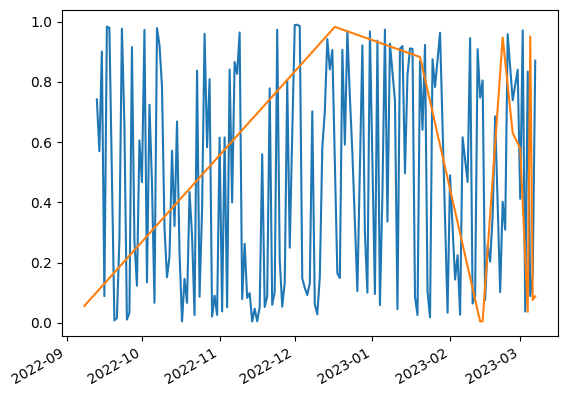

In [20]:
import matplotlib.pyplot as plt

# plot
plt.plot(np.unique(x),y)
plt.plot(np.unique(x_liv),y_liv)
# beautify the x-labels
plt.gcf().autofmt_xdate()

plt.show()

In [13]:
for index, txt in enumerate(ts_car.tolist()):
    text = preprocess(txt[0:514])
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    print(df_g_c.index[index])
    print(txt)
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")

2020-12-15
Been a pretty shit year for most people. But my little warrior been through it with her eyes, her low blood sugars. Her tumours and her Autism. Would mean loads in @GWijnaldum got to see this. Please help or go viral. @LFC @PeterMooreLFC @Carra23 https://t.co/X4Kcds9fMv
1) negative 0.5543
2) neutral 0.3474
3) positive 0.0983
2022-08-18
Introducing… MUNDIAL Magazine Issue 23. 

ZIZOU!

Exploring one of football’s gods through 10 defining games.

We can’t wait for you to read it.

Preorder MUNDIAL Issue 23 now.
1) positive 0.9144
2) neutral 0.0829
3) negative 0.0027
2022-09-13
#NewProfilePic https://t.co/flKewXFGfu@GingerPirlo_ @TalkinTactics Let it go!@TalkinTactics Another late winner for Liverpool via a corner.
1) positive 0.7418
2) neutral 0.2531
3) negative 0.0051
2022-09-14
RT @CBSSportsGolazo: Erling Haaland's goal had Pep Guardiola reminiscing about Johan Cruyff 🌟 https://t.co/QpdnzmCu1YErling Haaland's goal had Pep Guardiola reminiscing about Johan Cruyff 🌟 https://t.

KeyboardInterrupt: 